
# 2.2-kW PMSM

This example simulates sensorless vector control of a 2.2-kW PMSM drive.
Square-wave signal injection is used with a simple phase-locked loop.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, Sequence, SynchronousMachinePars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=4.3, f=75, P=2.2e3, tau=14)
base = BaseValues.from_nominal(nom, n_p=3)

Configure the system model.



In [4]:
mdl_par = SynchronousMachinePars(
    n_p=3, R_s=3.6, L_d=.036, L_q=.051, psi_f=.545)
machine = model.SynchronousMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [5]:
par = mdl_par  # Assume accurate machine model parameter estimates
cfg = control.CurrentReferenceCfg(par, nom_w_m=base.w, max_i_s=2*base.i)
ctrl = control.SignalInjectionControl(par, cfg, J=.015, T_s=250e-6)
# ctrl.current_ctrl = control.sm.CurrentControl(par, 2*np.pi*100)

Set the speed reference and the external load torque.



In [6]:
# Speed reference
times = np.array([0, .25, .25, .375, .5, .625, .75, .75, 1])*4
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w*.1
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=4)

Plot results in per-unit values.



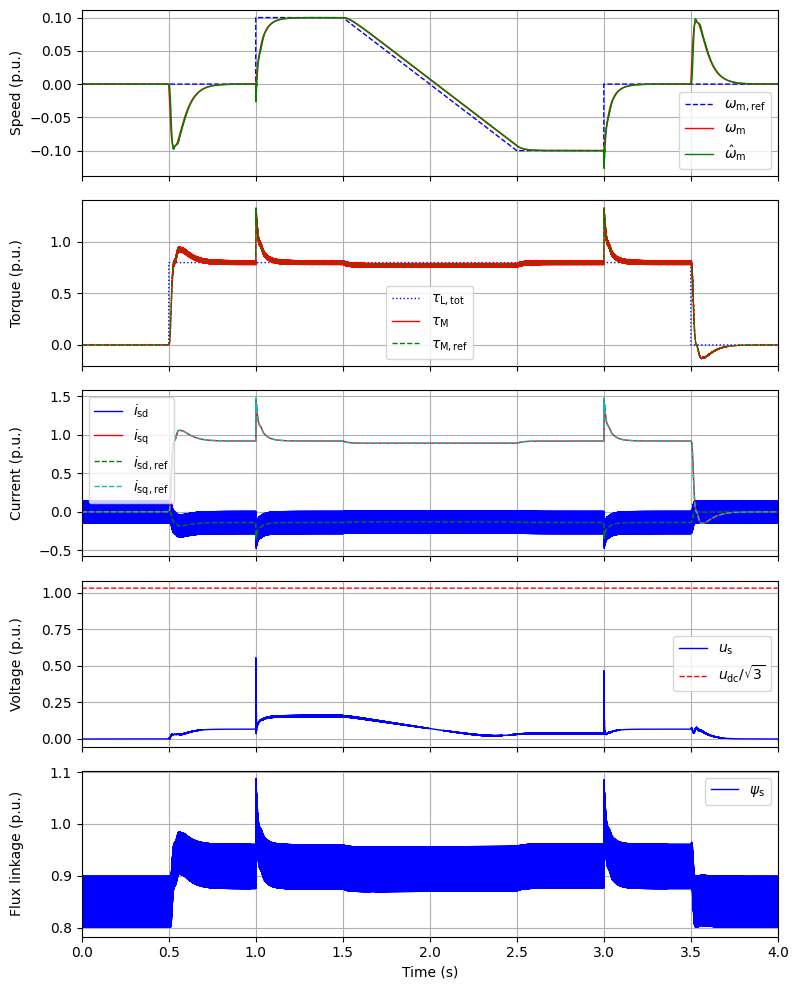

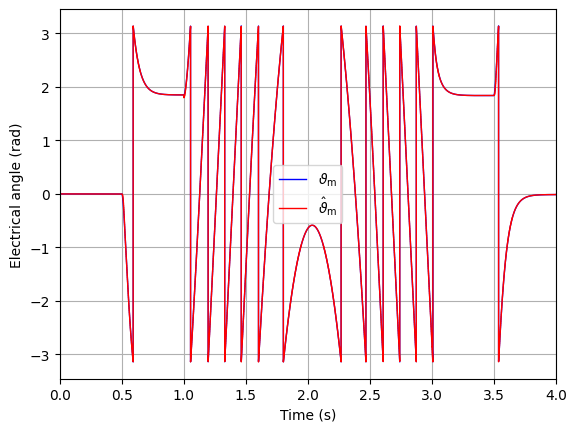

In [8]:
# Plot the "basic" figure
plot(sim, base)

# Plot also the angles
mdl = sim.mdl  # Continuous-time data
ctrl = sim.ctrl.data  # Discrete-time data
ctrl.t = ctrl.ref.t  # Discrete time

plt.figure()
plt.plot(
    mdl.machine.data.t,
    mdl.machine.data.theta_m,
    label=r"$\vartheta_\mathrm{m}$")
plt.plot(
    ctrl.t,
    ctrl.fbk.theta_m,
    ds="steps-post",
    label=r"$\hat \vartheta_\mathrm{m}$")
plt.legend()
plt.xlim(0, 4)
plt.xlabel("Time (s)")
plt.ylabel("Electrical angle (rad)")
plt.show()